# Assignment 1 - Option B - Jacob Hargreaves - 2401649

### Monte Carlo simulations for modelling a particle physics experiment

This notebook simulates a beam of partickes travelling along the $z$ axis with a mean veloicty of $2000ms^{-1}$. Each decays into a daughter particle after a mean lifetime of $2.5ms$ which is then propelled out of the decay point isotropically. Four tracking stations are placed at $ z = 30, 35, 40, 45m$ and are square surfaces of side length $5m$ which detect any daughter particles incident upon them with a resolution of $\pm0.01m$. This simulation displays the positions of all particles incident upon each of the four stations and analyses the breakdown of how many particles connect with each station. 

In [1]:
# importing the relevant libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from IPython.display import Markdown


In [2]:
# the base parameters are defined as stated in the assignment brief
# these are defined here to allow for testing througout the code
N = 10**6
mean_v = 2000
std_v = 50
Lambda = 0.0025
detector_positions = [30, 35, 40, 45]
a = b = 2.5

These first two functions create and decay a single particle according to the parameters given. $z$-velocity is drawn from a normal distributionn while decay time is drawn from an exponential distribution. 

In [3]:
# generate a beam of particles with velocities selected from a normal distribution with their initial positions equal to zero
# then generate a decay time for each particle based on an exponential distribution
# finally, calculates their decay position based on their velocities and the decay time

def generate_and_decay(N, mean_v, std_v, Lambda):

    velocities = np.random.normal(mean_v, std_v, N)
    decay_time = np.random.exponential(Lambda, N)
    decay_z_pos = decay_time * velocities

    return decay_z_pos


As each particle has it's $z$-velocity drawn from a normal distribution of mean $\mu_v = 20000ms^{-1}$ and it's decay time from an exponential distribution of mean $\tau = 2.5ms$, the mean distance travelled by a particle before decaying should be $5m$. 

The resulting distribution of the particles can be given by the probability density function of:

$$ f(z) = \int_0^\infty \frac{1}{b} N (\mu, \sigma^2) Exp(\lambda) db$$

which expands to:

$$ f(z) = \frac{\lambda}{\sqrt{2 \pi} \sigma} \int_0^\infty \frac{1}{b} e^{\left(-\frac{(z/b-\mu)^2}{2\sigma^2}-\lambda b\right)}db$$

The next cell tests the two functions above to check the distribution of the decay distances of the particles and check the mean decay distance. 



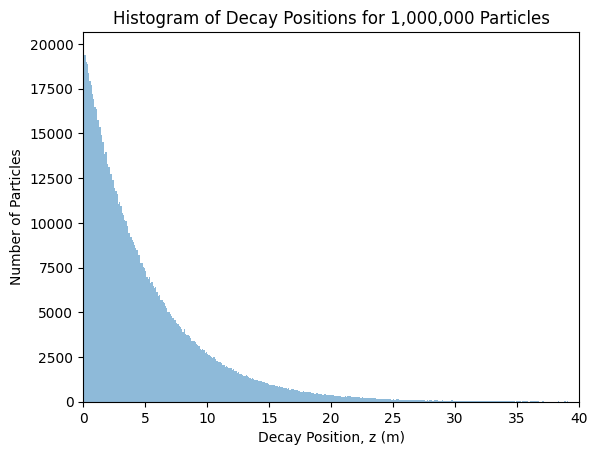

The mean Decay Distance is 4.996m, a 0.08% deviation from the expected value

In [4]:
# testing the distribution of the decay positions of the particles

decay_positions = []
decay_z_pos = generate_and_decay(N, mean_v, std_v, Lambda)

plt.hist(decay_z_pos, bins=np.arange(0, max(decay_z_pos), 0.1) - 0.5, alpha=0.5)
plt.xlabel('Decay Position, z (m)')
plt.ylabel('Number of Particles')
plt.title('Histogram of Decay Positions for 1,000,000 Particles')
plt.xlim(0, 40)
plt.show()

mean_decay_distance = np.mean(decay_z_pos)
true_mean_decay = mean_v * Lambda
percent_error = (np.abs(true_mean_decay - np.round(mean_decay_distance, 3))/ true_mean_decay)*100
Markdown(f"The mean Decay Distance is {mean_decay_distance:.3f}m, a {percent_error:.2f}% deviation from the expected value")        

The results above show the correct distribution, meaning the code runs as intended. 

These next cells create the initial direction of the daughter particle and calculate it's trajectory in the $x$ and $y$ axes. 

The initial direction of the daughter particle should be created isotropically as we are able to assume the momentum of the daughter particle is signaificantly higher than that of the parent particle. 

In [5]:
# function to select the daughter particle direction based on it being isotropic
# values of theta and phi are randomly drawn before being converted into cartesian coordinates
# the values are then normalised

def daughter_initial_direction(N):
    theta = np.arccos(1 - 2 * np.random.uniform(0, 1, N))
    phi = 2 * np.pi * np.random.uniform(0, 1, N)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    norm = np.sqrt(x**2 + y**2 + z**2)
    x /= norm
    y /= norm
    z /= norm
    return x, y, z


The code in the cell below tests the output of the $daughter\_initial\_direction$ function. It tests the distributions of $cos(\theta)$ and $\phi$, which should be uniform for an isotopic distribution. The distribution of $cos(\theta)$ is tested as to whether it is random to the 5% level. As $\phi$ is a direct product of $np.random$ it is assumed to be sufficently random. 

KS statistic: 0.0006
p-value: 0.8019
Yes, cos(θ) is uniformly distributed (isotropic)


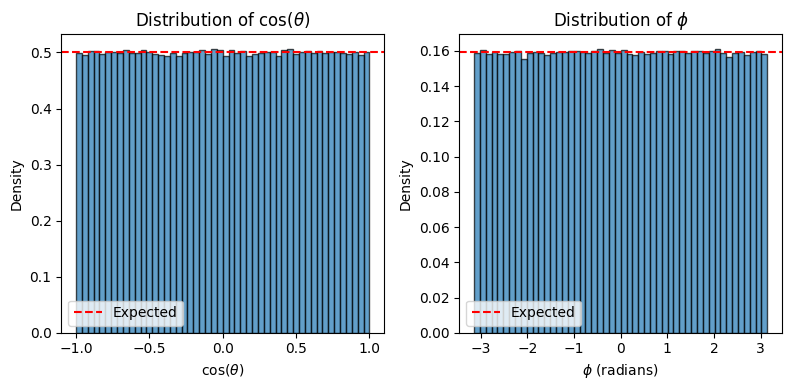

In [6]:
# a statistical test of the isotropic distribution

x, y, z = daughter_initial_direction(N)
cos_theta = z
phi = np.arctan2(y, x)
test_level = 0.05

ks_stat, p_value = stats.kstest(cos_theta, 'uniform', args=(-1, 2))

print(f"KS statistic: {ks_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value > test_level:
    print("Yes, cos(θ) is uniformly distributed (isotropic)")
else:
    print("No, cos(θ) is NOT uniformly distributed")


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(cos_theta, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axhline(y=0.5, color='r', linestyle='--', label='Expected')
plt.xlabel(r'$\cos(\theta)$')
plt.ylabel('Density')
plt.title(r'Distribution of $\cos(\theta)$')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(phi, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axhline(y=1/(2*np.pi), color='r', linestyle='--', label='Expected')
plt.xlabel(r'$\phi$ (radians)')
plt.ylabel('Density')
plt.title(r'Distribution of $\phi$')
plt.legend()

plt.tight_layout()
plt.show()



The daughte particle's decay is therefore shown to be isotropic. 

Next the equation of motion of each particle is calculated. The particles are assumed to travel linearly so the motion of each particle can be given by considering $x(z)$ and $y(z)$ together. 

In [7]:
# function to track the daughter particle at each tracking station
# a mask is used to only consider particles which decay before the first tracking station and move in the positive z direction
# the gradients and intercepts of each particle are calculated
# infinite gradient is used for invaid particles so they can never collide with a tracking station

def daughter_position_eqn(detector_positions, decay_z_pos, x, y, z):
    first_detector = min(detector_positions)
    valid_mask = (decay_z_pos < first_detector) & (z > 0)

    m_x = np.where(valid_mask, x / z, np.inf)
    m_y = np.where(valid_mask, y / z, np.inf)

    c_x = np.where(valid_mask, -m_x * decay_z_pos, 0)
    c_y = np.where(valid_mask, -m_y * decay_z_pos, 0)

    return m_x, m_y, c_x, c_y, valid_mask

The equation of the particles is then used to record a hit on the tracking stations. Normally distributed errors are added to each particle's hit to simulate the uncertainty in experiemntal equipment, the hits are also recorded with finite resolution.

In [8]:
# the true position of each particle at the z coordinate of each tracking station is calculated
# normally distributed errors and finite resolution are added
# the hits are recorded in hits_out array

def detect_hits(detector_positions, m_x, m_y, c_x, c_y, a, valid_mask):
    detector_z = np.asarray(detector_positions)
    num_events = len(m_x)

    # the true positions are calculated and particles which hit are counted
    x_true = m_x[:, None] * detector_z + c_x[:, None]
    y_true = m_y[:, None] * detector_z + c_y[:, None]
    
    in_bounds = ((-a < x_true) & (x_true < a) & (-a < y_true) & (y_true < a) & valid_mask[:, None])

    num_hits = in_bounds.sum(axis=1)

    # errors and finite resolution are applied, the measured values are recorded
    shape = x_true.shape
    x_err = np.random.normal(0, 0.01, shape)
    y_err = np.random.normal(0, 0.01, shape)

    x_meas = np.round(x_true, 2) + x_err
    y_meas = np.round(y_true, 2) + y_err

    # record the hits and their errors in the hits_out array, applying the mask to reduce uneccisary processes
    hits_out = np.zeros((num_events, 20))
    for i in range(num_events):
        idx = np.where(in_bounds[i])[0]
        n = min(len(idx), 4)

        for k in range(n):
            j = idx[k]
            base = 5 * k
            hits_out[i, base+0] = x_meas[i, j]
            hits_out[i, base+1] = abs(x_err[i, j])
            hits_out[i, base+2] = y_meas[i, j]
            hits_out[i, base+3] = abs(y_err[i, j])
            hits_out[i, base+4] = detector_z[j]

    return num_hits, hits_out


Finally, the whole simulation is pulled together. The decay positions, daughter particle directions and motion equations are calculated. The hits on the tracking stations are then registered and recorded and the results are oulled together into a data frame for easy use

In [9]:
# bringing all parts of the simuation together and returning the important data as a pandas data frame

def simulation(N = 10**6, mean_v = 2000, std_v = 50, Lambda = 0.0025, detector_positions = [30,35,40,45]):
    
    decay_z_pos = generate_and_decay(N, mean_v, std_v, Lambda)
    x, y, z = daughter_initial_direction(N)
    m_x, m_y, c_x, c_y, valid_mask = daughter_position_eqn(detector_positions, decay_z_pos, x, y, z)
    
    num_hits, hits_out = detect_hits(detector_positions, m_x, m_y, c_x, c_y, a, valid_mask)

    column_names = ['x1', 'x1_err', 'y1', 'y1_err', 'z1', 'x2', 'x2_err', 'y2', 'y2_err', 'z2', 
                    'x3', 'x3_err', 'y3', 'y3_err', 'z3', 'x4', 'x4_err', 'y4', 'y4_err', 'z4']
    hit_positions_df = pd.DataFrame(hits_out, columns=column_names)

    return hit_positions_df, num_hits



With all of the different parts of the simulation defined above, we can call the simulation function and visualise the results. 

In [10]:
# the simulation is run

run, num_hits = simulation(N, mean_v, std_v, Lambda, detector_positions)    

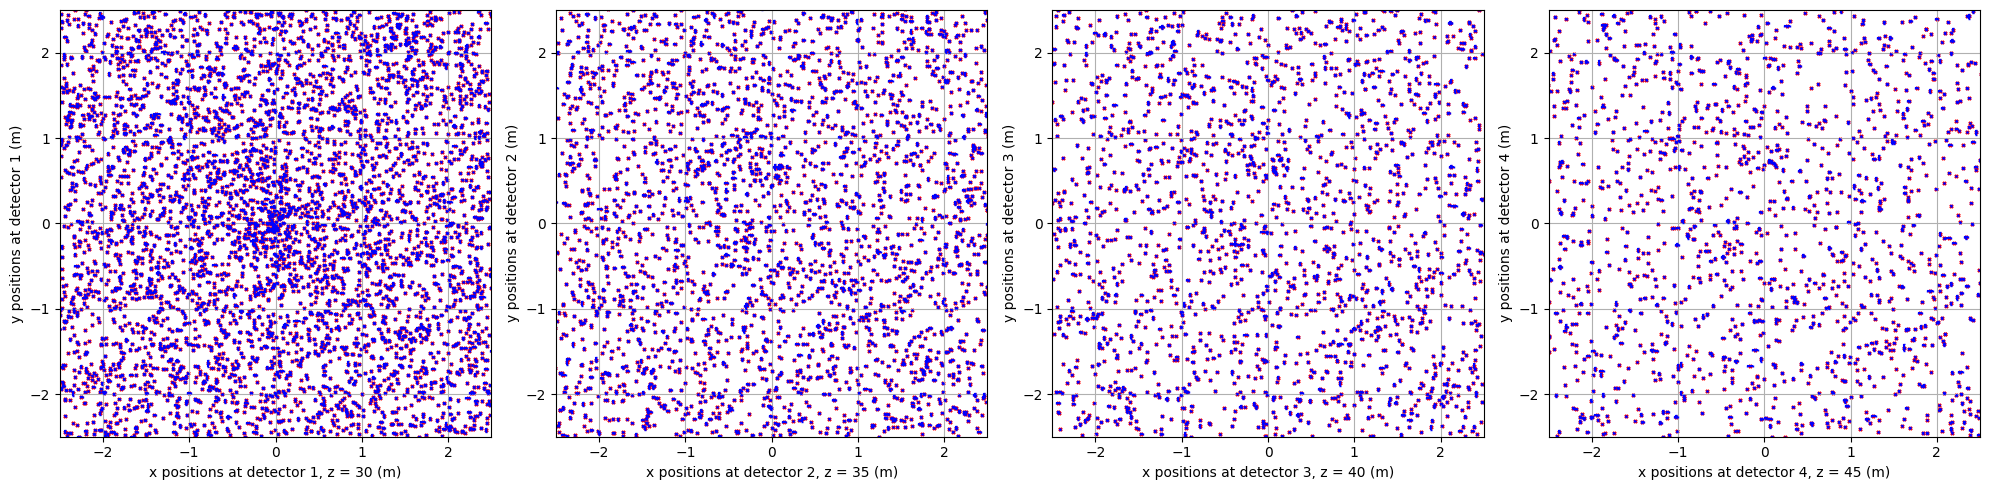

In [11]:
# plotting the distributions of the particle hits on each tracking station

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax_i in enumerate(axes):
    xcol = f'x{i+1}'
    ycol = f'y{i+1}'
    mask = (run[xcol] != 0) | (run[ycol] != 0) 
    ax_i.scatter(run.loc[mask, xcol], run.loc[mask, ycol], s=5, color='red', marker="x")
    ax_i.errorbar(run.loc[mask, xcol], run.loc[mask, ycol], xerr=run.loc[mask, f'{xcol}_err'], yerr=run.loc[mask, f'{ycol}_err'], fmt='none', ecolor='blue', capsize=1)
    ax_i.set_xlabel(f'x positions at detector {i+1}, z = {30 +i*5} (m)')
    ax_i.set_ylabel(f'y positions at detector {i+1} (m)')
    ax_i.set_xlim(-2.5, 2.5)
    ax_i.set_ylim(-2.5, 2.5)
    ax_i.grid(True)
plt.tight_layout()
plt.show()


The cell above displays the distributions of the particles registered at each tracking station. As we would expect the first tracking station records the largest number of hits and the number detected by each further station decreases every time. Furthermore, there is an intial concentration around the origin of stn. 1, this is due to the fact that some particles will decay very close to the detector and distribution of hits should be skewed towards this point and decrease outwards. 

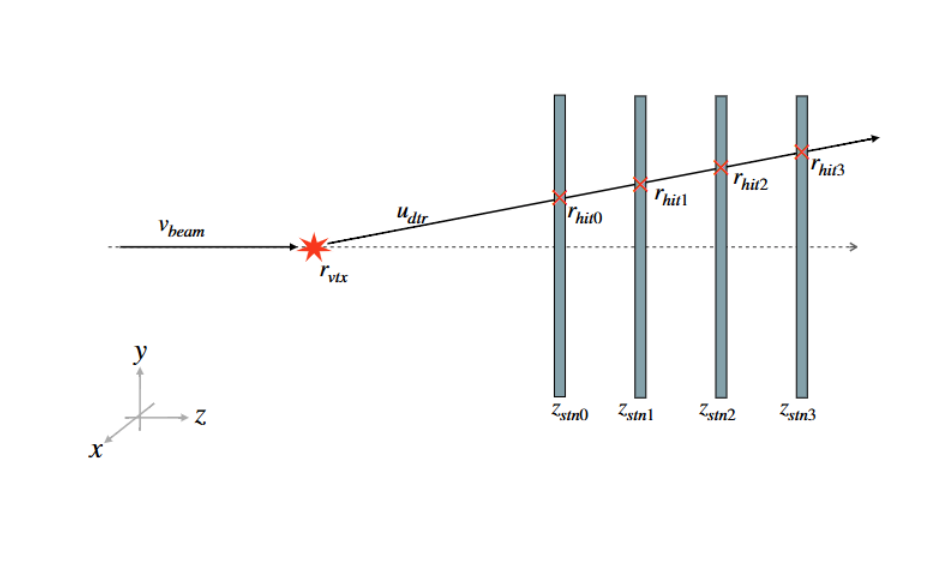



This is a copy of the diagram from the assignment brief. To validate the data from the simulation above, the expected values have been calculated.

Using the base parameters given in the brief and a few others:
* $N = 10^6$ particles
* $\tau = 2.5ms$
* $\mu_v = 2000ms^{-1}$
* $z_{stn} = 30, 35, 40, 45m$
* stn size: $\Delta x = 2a = 5m, \Delta y = 2b = 5m$
* $\sigma_{x, y} = 0.01m$

As found above, the mean $z$ value of the decay position of the particle, $r_{vtx}$, is 5m which gives a simplistic estimate of the number of particles hitting the first tracking station to be:

$$ N_{1} = N  \frac{\Omega}{4\pi}$$

Here $\Omega$ is the solid angle of the first square detector, given by:

$$ \Omega = 4 \arctan \left(\frac{ab}{R\sqrt{R^2 + a^2 + b^2}}\right)$$

Where $R$ is the distance of the detector from the mean value of $r_{vtx}$. 

However, in reality the number of particles which collide with the first tracking station is much greater as some particles decay closer to the detector than this mean distance of 25 meters and the solid angle increases as $r_{vtx}$ increases. The probability distribution function given above can be multiplied by the equation for the solid angle fraction and the total number of particles, $N$, to give the number of particles expected to decay at a value of $z$ and still collide with the first racking station, $A(z)$. Integrating over $z$ will then display the total number of particles incident on the first tracking station, $N_{1}$:

$$ A(z) = N \left(\frac{\lambda}{\sqrt{2 \pi \sigma}} \int_0^\infty \frac{1}{b} e^{\left(-\frac{(z/b-\mu)^2}{2\sigma^2}-\lambda b\right)}db \right ) \left( \frac{4 \arctan \left(\frac{ab}{R\sqrt{R^2 + a^2 + b^2}}\right)}{4 \pi} \right)$$

for $N = 10^6$:

$$ N_{1} = \int_0^{30} A(z) dz = 4505 $$

As all particles are assumed to travel linearly, no particles which miss detector one can hit any of the later detectors. 




In [12]:
num_hits_total = (run['x1'] != 0).sum()
num_expected = 4505
percent_error = (np.abs(num_expected - num_hits_total)/num_expected)*100

Markdown(f"Total number of hits to the first tracking station: {num_hits_total}, a {percent_error:.2f}% deviation from the expected value.")

Total number of hits to the first tracking station: 4563, a 1.29% deviation from the expected value.

The next cells analyse the data in the outputted data frame and the hit list. 

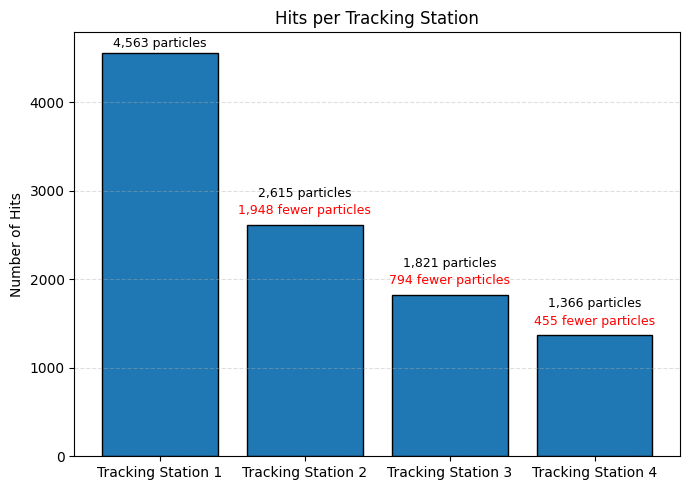

In [13]:
# this cell creates a bar chart of the number of particles hitting each tracking station
# it includes labels of the number of particles and the change in particles from the previous station

hit_1 = (run['x1'] != 0).sum()
hit_2 = (run['x2'] != 0).sum()
hit_3 = (run['x3'] != 0).sum()
hit_4 = (run['x4'] != 0).sum()

labels = ['Tracking Station 1', 'Tracking Station 2', 'Tracking Station 3', 'Tracking Station 4']
values = [hit_1, hit_2, hit_3, hit_4]

fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(labels, values, edgecolor='black')
ax.set_ylabel('Number of Hits')
ax.set_title('Hits per Tracking Station')
ax.grid(axis='y', linestyle='--', alpha=0.4)

for i, bar in enumerate(bars):
    h = int(bar.get_height())

    # annotate the bars with the number of particles which are detected
    if i == 0:
        ax.annotate(f'{h:,} particles', xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 2), textcoords='offset points', ha='center', va='bottom', fontsize=9)
    else:
        ax.annotate(f'{h:,} particles', xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 18), textcoords='offset points', ha='center', va='bottom', fontsize=9)

    # annotate the bars with the difference between the number of particles from the previous bar
    if i == 0:
        diff_text = ''
    else:
        diff = values[i] - values[i-1]
        diff_text = f'{np.abs(diff):,} fewer particles'

    ax.annotate(diff_text, xy=(bar.get_x() + bar.get_width() / 2, h),
                xytext=(0, 15), textcoords='offset points', ha='center', va='top', fontsize=9, color='red')

plt.tight_layout()
plt.show()

This bar chart display of the number of hits recorded by each tracking station. This agrees with the expected results as the particles which decay closest to the first tracking station have a far higher probability of colliding with it due to a larger solid angle. Yet for a particle decaying at $z\approx 25$, $\Omega_1 \gg \Omega_2$ and $\Omega_1 - \Omega_2$ is far greater for this particle than for one decaying at $z\approx 2$, further supporting the point that many particles will collide with the first station but miss all others. 

The distribution of the absolute values of $x$ and $y$ are shown below. this is to test the hypothesis that the particles are more likely to collide at the centre of the tracking station due to the decays all occuring at the origin of the $x, y$ plane. 

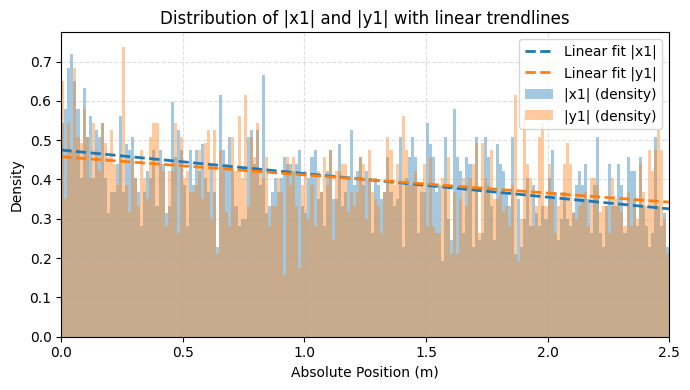

In [14]:
# Compute the distribution of the absolute values of x and y for the first tracking station
# a linear fit is applied to both the x and the y data to show the negatuve gradient

mask = run['x1'] != 0
x1_abs = run.loc[mask, 'x1'].abs()
y1_abs = run.loc[mask, 'y1'].abs()

plt.figure(figsize=(7,4))
bins = np.linspace(0, 2.5, 201)

# histogram for absolute x values
hist_x, edges_x = np.histogram(x1_abs, bins=bins, density=True)
centers_x = 0.5 * (edges_x[:-1] + edges_x[1:])
bar_width = edges_x[1] - edges_x[0]
plt.bar(centers_x, hist_x, width=bar_width, alpha=0.4, color='C0', label='|x1| (density)')

# histogram for absolut y values
hist_y, edges_y = np.histogram(y1_abs, bins=bins, density=True)
centers_y = 0.5 * (edges_y[:-1] + edges_y[1:])
plt.bar(centers_y, hist_y, width=bar_width, alpha=0.4, color='C1', label='|y1| (density)')

# linear fit for x
valid_x = np.isfinite(hist_x)
coeffs_x = np.polyfit(centers_x[valid_x], hist_x[valid_x], 1)
line_x = np.poly1d(coeffs_x)
xs = np.linspace(0, 2.5, 400)
plt.plot(xs, line_x(xs), color='C0', linestyle='--', lw=2, label=f'Linear fit |x1|')

# linear fit for y
valid_y = np.isfinite(hist_y)
coeffs_y = np.polyfit(centers_y[valid_y], hist_y[valid_y], 1)
line_y = np.poly1d(coeffs_y)
plt.plot(xs, line_y(xs), color='C1', linestyle='--', lw=2, label=f'Linear fit |y1|')

plt.xlabel('Absolute Position (m)')
plt.ylabel('Density')
plt.title('Distribution of |x1| and |y1| with linear trendlines')
plt.xlim(0, 2.5)
plt.grid( linestyle='--', alpha=0.4)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

The resulting histogram and trend lines support the hypothesis and display a slightly centerally skewed distribution of both x and y. 

Throughout the simulatyion the results support the expected values and show clear agreement with the theory. The simulation continues to run successfully and quickly with the format provided. 